In [47]:
import csv
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [48]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [49]:
NUM_CLASSES = 27

# Dataset reading

In [50]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [51]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [53]:
def reshape_for_lstm(data):
    samples = data.shape[0]
    return data.reshape(samples, 21, 2)  # 21 keypoints as "time steps", 2 features (x,y) per step

X_train_reshaped = reshape_for_lstm(X_train)
X_test_reshaped = reshape_for_lstm(X_test)

# Model building

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(21, 2)),

    # It's good practice to regularize the LSTM layer too
    tf.keras.layers.LSTM(32, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dropout(0.3),

    # Add the regularizer to your Dense layers
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

i:\Development\Minor Project\Visual Voice\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [55]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 27)             │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,647 (22.06 KB)

 Trainable params: 5,647 (22.06 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [57]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [58]:
model.fit(
    X_train_reshaped,  # Use reshaped data
    y_train, # This is now correct as sample counts match
    epochs=1000,
    batch_size=128,
    validation_data=(X_test_reshaped, y_test),  # Use reshaped test data
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0650 - loss: 3.2379
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0651 - loss: 3.2372 - val_accuracy: 0.1306 - val_loss: 2.4290
Epoch 2/1000
292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1874 - loss: 2.3841
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1886 - loss: 2.3801 - val_accuracy: 0.3778 - val_loss: 1.8616
Epoch 3/1000
297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3017 - loss: 1.9843
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3018 - loss: 1.9836 - val_accuracy: 0.4449 - val_loss: 1.6105
Epoch 4/1000
299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3360 - loss: 1.8379
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
30

In [59]:
val_loss, val_acc = model.evaluate(X_test_reshaped, y_test, batch_size=128)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9954 - loss: 0.1559


In [60]:
model = tf.keras.models.load_model(model_save_path)

In [61]:
test_sample = X_test[0].reshape(1, 21, 2)
predict_result = model.predict(test_sample)
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
[0.0000000e+00 2.1031268e-37 0.0000000e+00 1.5588774e-33 6.4968206e-22
 0.0000000e+00 5.4642051e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.2223731e-36 0.0000000e+00 6.2077964e-04 1.7167565e-08 5.8888932e-24
 0.0000000e+00 2.1913248e-13 1.5556982e-19 1.9233109e-08 2.6298606e-09
 3.1097889e-12 6.3631460e-14 9.2752349e-26 9.9937588e-01 0.0000000e+00
 3.3133099e-06 0.0000000e+00]
23


# Confusion matrix

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


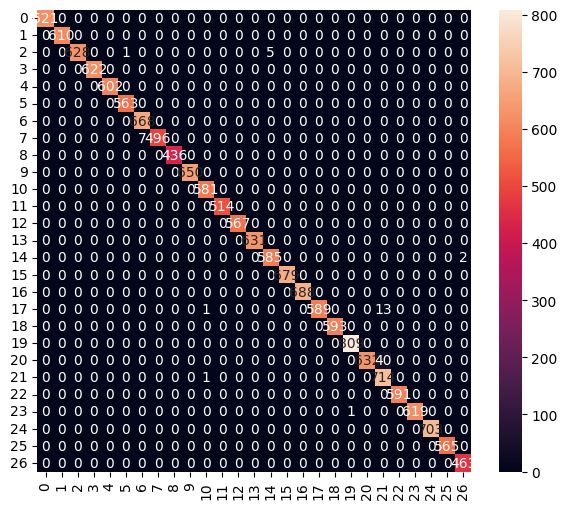

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       621
           1       1.00      1.00      1.00       610
           2       1.00      0.99      1.00       634
           3       1.00      1.00      1.00       622
           4       1.00      1.00      1.00       602
           5       1.00      1.00      1.00       563
           6       0.99      1.00      0.99       668
           7       1.00      0.99      0.99       503
           8       1.00      1.00      1.00       436
           9       1.00      1.00      1.00       650
          10       1.00      1.00      1.00       581
          11       1.00      1.00      1.00       514
          12       1.00      1.00      1.00       567
          13       1.00      1.00      1.00       631
          14       0.99      1.00      0.99       587
          15       1.00      1.00      1.00       679
          16       1.00      1.00      1.00       688
     

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [63]:
model.save(model_save_path, include_optimizer=False)

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)


converter.experimental_enable_resource_variables = True

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

converter._experimental_lower_tensor_list_ops = False

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quantized_model = converter.convert()


with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print(f"TFLite model saved to: {tflite_save_path}")


INFO:tensorflow:Assets written to: C:\Users\ISHABR~1\AppData\Local\Temp\tmp7te_d0h3\assets


INFO:tensorflow:Assets written to: C:\Users\ISHABR~1\AppData\Local\Temp\tmp7te_d0h3\assets


Saved artifact at 'C:\Users\ISHABR~1\AppData\Local\Temp\tmp7te_d0h3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21, 2), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)
Captures:
  2271897713552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271897704720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271897713360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271897705104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271897712400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271819038800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271819040528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271819039760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2271819039376: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to: model/keypoint_classifier/keypoint_classifier.tflite


# Inference test

In [65]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [66]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [67]:
interpreter.set_tensor(input_details[0]['index'], X_test_reshaped[0:1])

In [68]:

interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [69]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.0000000e+00 1.7191313e-37 0.0000000e+00 1.2495300e-33 5.3605585e-22
 0.0000000e+00 4.5663883e-34 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.9868030e-36 0.0000000e+00 5.9710117e-04 1.4076221e-08 5.3671615e-24
 0.0000000e+00 2.2115738e-13 1.2811682e-19 1.8875879e-08 2.1241700e-09
 3.1114881e-12 5.4982006e-14 8.0108714e-26 9.9939966e-01 0.0000000e+00
 3.2389282e-06 0.0000000e+00]
23
